# Customer Churn Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#### Data Preparation based on EDA

In [2]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
    
    return df

In [3]:
import pandas as pd

datapreparation_filepath = r"C:\Users\Raj\Downloads\WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(datapreparation_filepath)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.isnull().any().any()

False

## Model Building

I am going to build and tune random forest model because in this case tree based method would perform better. I am also interested in individual customer's churning probability and in understanding how the model calculates it using Shap values.

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=111, stratify = df.Churn)

In [7]:
x = df.columns[df.columns!="Churn"]
y = "Churn"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]

In [8]:
#function for model fitting
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]
    
    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()

### Hyperparameters Tuning

#### Grid 1: Selecting class weight and estimators

In [10]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset
# df = pd.read_csv('your_dataset.csv')

# Identify categorical columns for label encoding
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Perform label encoding on categorical variables
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Handle missing values (if any)
df.fillna(0, inplace=True)  # Replace missing values with 0, adjust as needed

# Convert remaining non-numeric columns to numeric (if any)
non_numeric_columns = df.select_dtypes(exclude=['number']).columns
for col in non_numeric_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Split data into features and target
features = df.drop('Churn', axis=1)
target = df['Churn']

# Split data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [300, 500, 700, 900, 1100, 1300],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize Random Forest model and GridSearchCV
rf_model = RandomForestClassifier()
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1, scoring='f1')

# Fit the model
grid1.fit(train_x, train_y)

# Print best parameters and corresponding F1 score
print("Best Parameters:", grid1.best_params_)
print("Best F1 Score:", grid1.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 

Best Parameters: {'max_features': None, 'n_estimators': 900}
Best F1 Score: 0.5624858242865484


In [11]:
grid1.best_estimator_

RandomForestClassifier(max_features=None, n_estimators=900)

<Axes: xlabel='param_max_features', ylabel='param_n_estimators'>

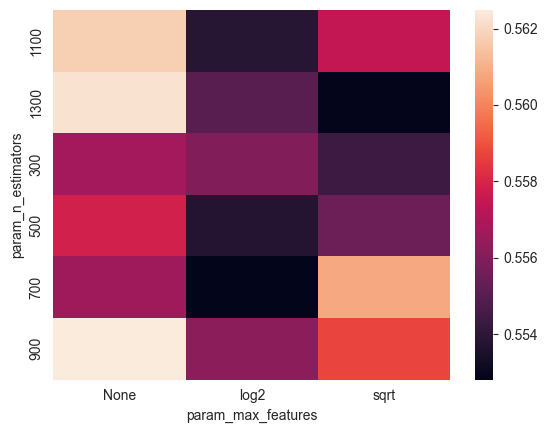

In [12]:
dt = pd.DataFrame(grid1.cv_results_)
dt.param_max_features = dt.param_max_features.astype(str)
dt.param_n_estimators = dt.param_n_estimators.astype(str)

table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators', 
                       columns='param_max_features')
     
sns.heatmap(table)

In [13]:
grid1.best_score_

0.5624858242865484

#### Grid 2: Selecting max depth and split criterion

In [18]:
param_grid2 = {'max_features':['sqrt', 'log2', None],
               'n_estimators':[1000, 1100, 1200],
               'criterion': ['entropy', 'gini'],    
               'max_depth': [7, 9, 11, 13, 15, None]
              }

# Initialize Random Forest model and GridSearchCV
rf_model = RandomForestClassifier()
grid2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring='f1')

# Fit the model
grid2.fit(train_x, train_y)

# Print best parameters and corresponding F1 score
print("Best Parameters:", grid2.best_params_)
print("Best F1 Score:", grid2.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


Best Parameters: {'max_features': None, 'n_estimators': 900}
Best F1 Score: 0.5624858242865484


In [19]:
grid2.best_estimator_

RandomForestClassifier(max_depth=13, n_estimators=1000)

<Axes: xlabel='param_criterion', ylabel='param_max_depth'>

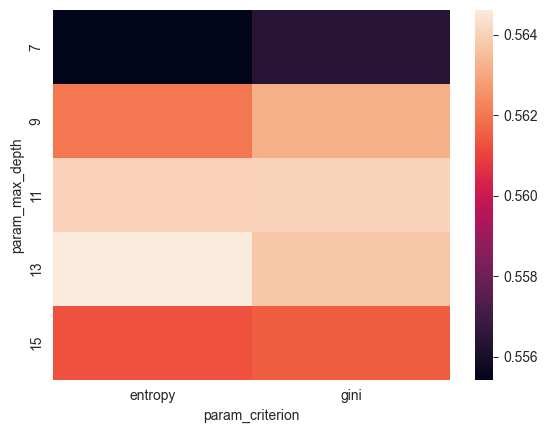

In [20]:
dt = pd.DataFrame(grid2.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_criterion')
     
sns.heatmap(table)

<Axes: xlabel='param_n_estimators', ylabel='param_max_depth'>

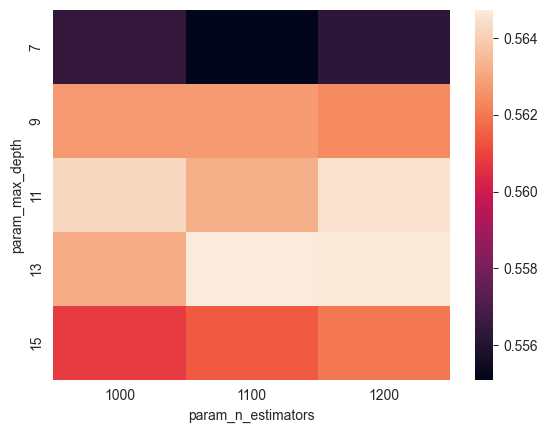

In [21]:
table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_n_estimators')
     
sns.heatmap(table)

In [22]:
grid2.best_score_

0.5685383275356385

Checking if other depth and estimator value results better

In [23]:
param_grid2_2 = {'max_features':['sqrt', 'log2','auto', None],
          'n_estimators':[950, 1000, 1050],
           'criterion': ['entropy'],    
          'max_depth': [10, 11, 12],
         }

rf_model = RandomForestClassifier()
grid2_2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2_2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2_2.fit(train_x, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10, 11, 12],
                         'max_features': ['sqrt', 'log2', 'auto', None],
                         'n_estimators': [950, 1000, 1050]},
             scoring='f1', verbose=1)

In [24]:
grid2_2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, max_features='log2',
                       n_estimators=1000)

In [25]:
grid2_2.best_score_

0.5725413517671455

#### Grid 3: Selecting minimum samples leaf and split

In [26]:
param_grid3 = {'max_features':['sqrt', 'log2','auto', None],
          'n_estimators':[1000],
           'criterion': ['entropy'],    
          'max_depth': [10],
          'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [2, 4, 6, 8]
         }

rf_model = RandomForestClassifier()
grid3 = GridSearchCV(estimator=rf_model, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid3.fit(train_x, train_y)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['sqrt', 'log2', 'auto', None],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [27]:
grid3.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       min_samples_leaf=7, min_samples_split=6,
                       n_estimators=1000)

<Axes: xlabel='param_min_samples_split', ylabel='param_min_samples_leaf'>

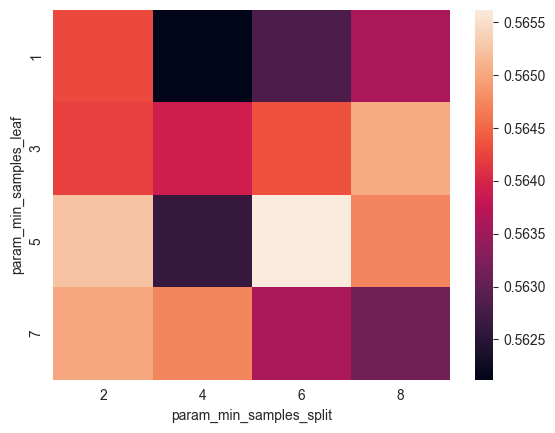

In [28]:
dt = pd.DataFrame(grid3.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_min_samples_leaf', 
                       columns='param_min_samples_split')
     
sns.heatmap(table)

In [29]:
grid3.best_score_

0.5687929750799281

#### Grid 4: Selecting class weight

In [30]:
param_grid4 = {'class_weight':[{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
            'max_features':['sqrt', 'log2','auto', None],
          'n_estimators':[1000],
           'criterion': ['entropy'],    
          'max_depth': [10],
          'min_samples_leaf': [1],
          'min_samples_split': [8]
         }

rf_model = RandomForestClassifier()
grid4 = GridSearchCV(estimator=rf_model, param_grid=param_grid4, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid4.fit(train_x, train_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
9 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 63

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['sqrt', 'log2', 'auto', None],
                         'min_samples_leaf': [1], 'min_samples_split': [8],
                         'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [31]:
grid4.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 3}, criterion='entropy',
                       max_depth=10, min_samples_split=8, n_estimators=1000)

<Axes: ylabel='param_class_weight'>

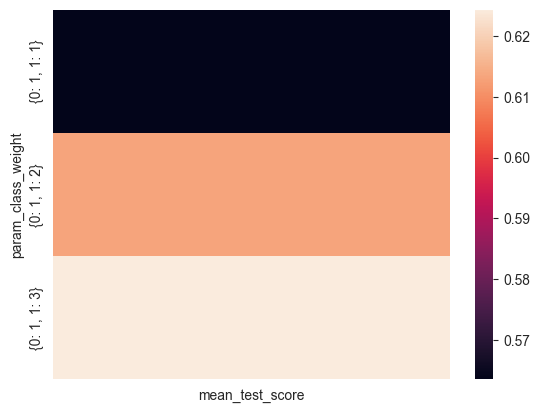

In [32]:
dt = pd.DataFrame(grid4.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')
     
sns.heatmap(table)

In [33]:
grid4.best_score_

0.6289469297153619

### Final Model

In [49]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='entropy', max_depth=10, max_features=['sqrt', 'log2','auto', None],
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, 
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [57]:
from sklearn.ensemble import RandomForestClassifier

def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf='coefficients'):
    # Explicitly define max_features parameter
    algo = RandomForestClassifier(
        max_features='log2' # or another valid value
        # Other parameters...
    )
    
    algo.fit(training_x, training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:, 1]

# Call the function with your desired algorithm and other parameters
churn_prediction(model, train_x, train_y, test_x, test_y, x, "max_features")


In [58]:
churn_prediction(model, train_x, train_y, test_x, test_y, x,"max_features")

Checking the model's performance on train data itself

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define your RandomForestClassifier model with the correct max_features value
model = RandomForestClassifier(
    n_estimators=100,  # Adjust other parameters as needed
    max_features='sqrt'  # Set to a valid value: 'sqrt', 'log2', float, int, or None
)

# Assuming you have train_x and train_y defined
train_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='f1')

# Print the cross-validated scores
print("Cross-validated F1 scores:", train_scores)
print("Mean F1 score:", train_scores.mean())


Cross-validated F1 scores: [0.59622642 0.54117647 0.53742802 0.56554307 0.51004016]
Mean F1 score: 0.5500828281037647


In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define your RandomForestClassifier model with the correct max_features value
model = RandomForestClassifier(
    n_estimators=100,  # Adjust other parameters as needed
    max_features='log2'  # Set to a valid value: 'sqrt', 'log2', float, int, or None
)

# Assuming you have train_x and train_y defined
train_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='f1')

# Print the cross-validated scores
print("Cross-validated F1 scores:", train_scores)
print("Mean F1 score:", train_scores.mean())

Cross-validated F1 scores: [0.60661765 0.5443787  0.53714286 0.55390335 0.52295409]
Mean F1 score: 0.5529993279935614


In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define the values of max_features to iterate through
max_features_values = ['sqrt', 'log2', None]

# Iterate through different max_features values
for max_features_value in max_features_values:
    # Create RandomForestClassifier with the current max_features value
    model = RandomForestClassifier(
        n_estimators=100,  # Adjust other parameters as needed
        max_features=max_features_value
    )
    
    # Assuming you have train_x and train_y defined
    train_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='f1')
    
    # Print the results
    print("Max Features:", max_features_value)
    print("Cross-validated F1 scores:", train_scores)
    print("Mean F1 score:", train_scores.mean())
    print()


Max Features: sqrt
Cross-validated F1 scores: [0.59398496 0.54223969 0.53308129 0.53604436 0.51703407]
Mean F1 score: 0.5444768727873454

Max Features: log2
Cross-validated F1 scores: [0.59519409 0.53438114 0.50972763 0.57466919 0.51115619]
Mean F1 score: 0.5450256449468396

Max Features: None
Cross-validated F1 scores: [0.59336824 0.56761905 0.55677656 0.55677656 0.52      ]
Mean F1 score: 0.5589080797038912



In [63]:
np.mean(train_scores)

0.5589080797038912

As we can see that the performance of the model on test data is same as training data. So, we can conclude that there is no overfitting and underfitting.

#### Saving model

In [64]:
import pickle
pickle.dump(model, open('model.pkl','wb'))

## Explaining the model

In [72]:
import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp
from pdpbox import info_plots


ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\metaestimators.py)

In [75]:
import sklearn.utils.metaestimators.if_delegate_has_method

ModuleNotFoundError: No module named 'sklearn.utils.metaestimators.if_delegate_has_method'; 'sklearn.utils.metaestimators' is not a package

In [69]:
import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\metaestimators.py)

In [77]:
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

NameError: name 'PermutationImportance' is not defined

Visualizing how the partial dependance plots look for top features

#### Internet Service: Fiber Optic

In [78]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
                        feature='InternetService_Fiber optic')
pdp.pdp_plot(pdp_p, 'InternetService_Fiber optic')
plt.show()

NameError: name 'pdp' is not defined

#### Payment Method: Mailed Check

In [76]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
                        feature='PaymentMethod_Mailed check')
pdp.pdp_plot(pdp_p, 'PaymentMethod_Mailed check')
plt.show()

NameError: name 'pdp' is not defined

#### Monthly Charges

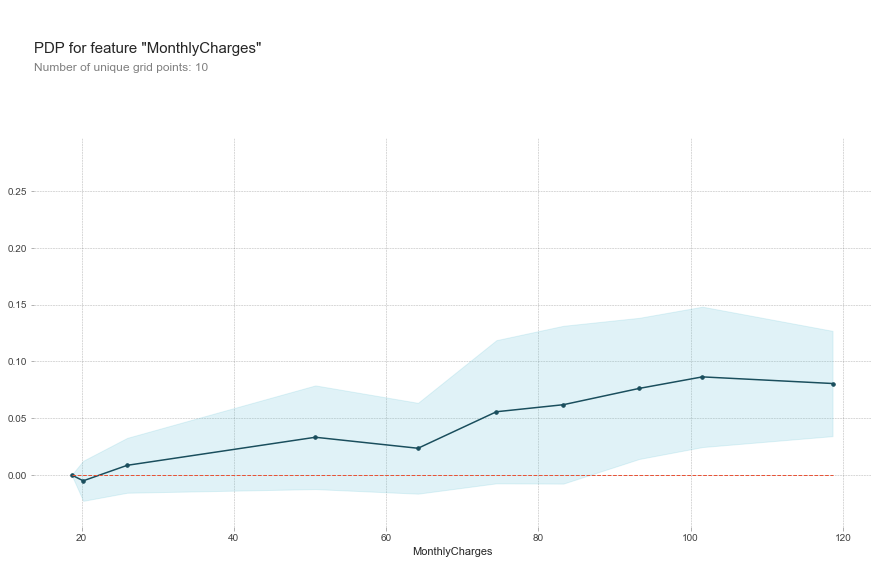

In [ ]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, feature='MonthlyCharges')
pdp.pdp_plot(pdp_p, 'MonthlyCharges')
plt.show()

#### Total Charges

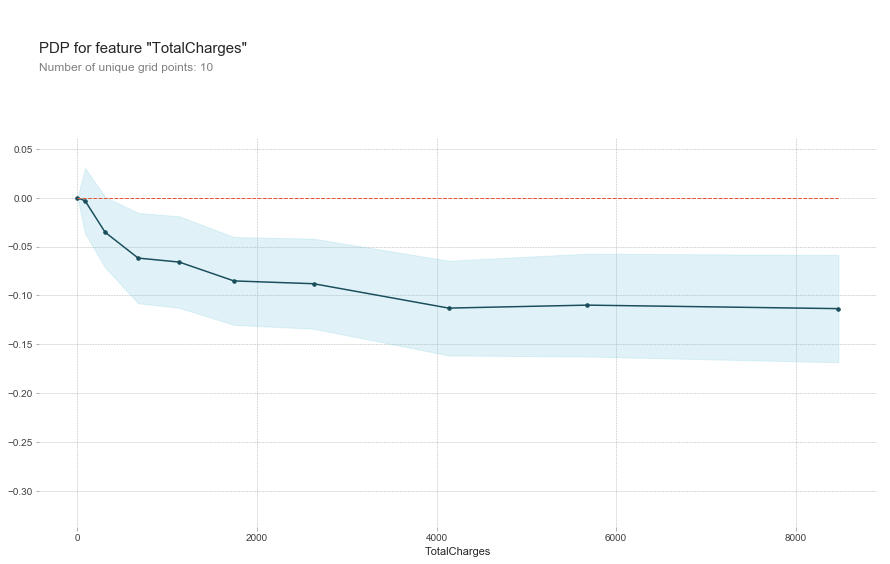

In [ ]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, feature='TotalCharges')
pdp.pdp_plot(pdp_p, 'TotalCharges')
plt.show()

#### Contract - Two years

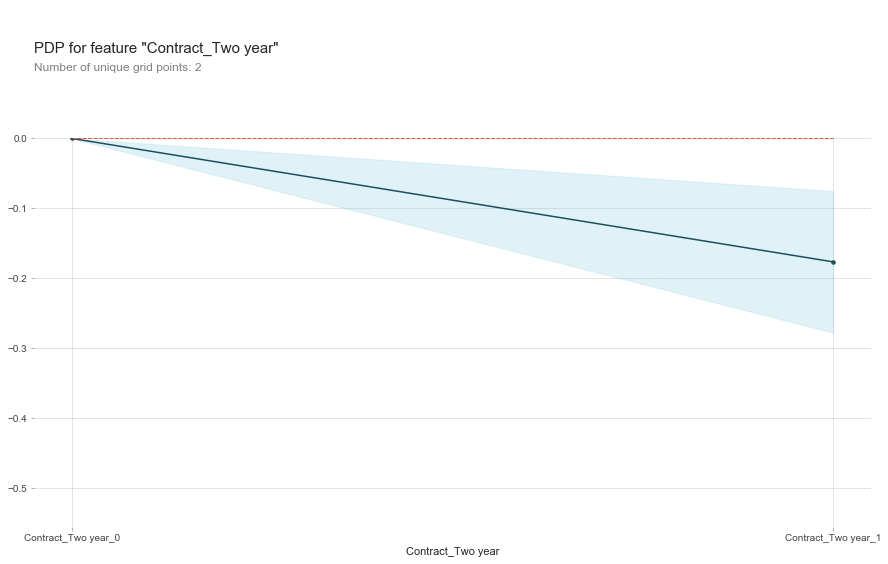

In [ ]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
                        feature='Contract_Two year')
pdp.pdp_plot(pdp_p, 'Contract_Two year')
plt.show()

#### Tenure

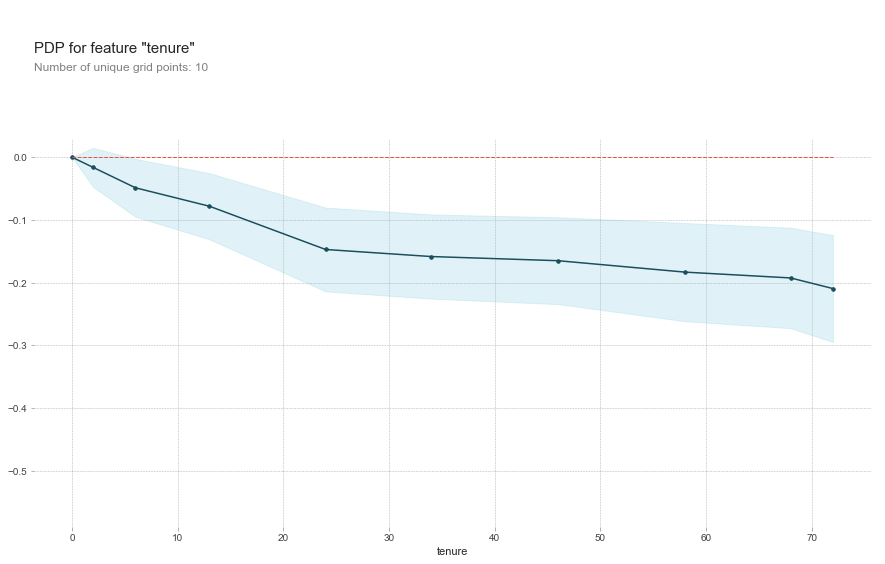

In [ ]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
                        feature='tenure')
pdp.pdp_plot(pdp_p, 'tenure')
plt.show()

### Shap Values

In [ ]:
import shap 
shap.initjs()

import joblib

In [ ]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(test_x.iloc[0]))
shap.force_plot(explainer.expected_value[1], shap_values[1], test_x.iloc[0])

In [ ]:
# Saving Explainer
ex_filename = 'explainer.bz2'
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))

['explainer.bz2']

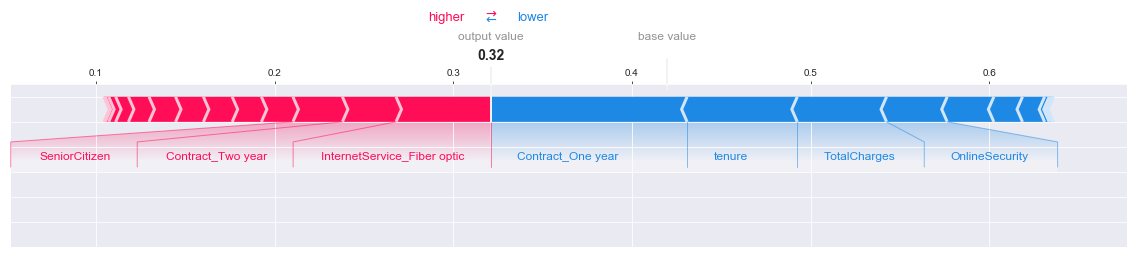

In [ ]:
explainer = joblib.load(filename="explainer.bz2")
shap_values = explainer.shap_values(np.array(test_x.iloc[0]))
shap.force_plot(explainer.expected_value[1], shap_values[1], list(test_x.columns), matplotlib = True, show = False).savefig('static/images/shap.png', bbox_inches="tight")    

### Gauge Chart 

In [ ]:
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'], \
          colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], Probability=1, fname=False): 
    
    N = len(labels)
    colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(4)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, 'Churn Probability ' + np.round(Probability,2).astype(str), horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = (1-Probability)*180
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

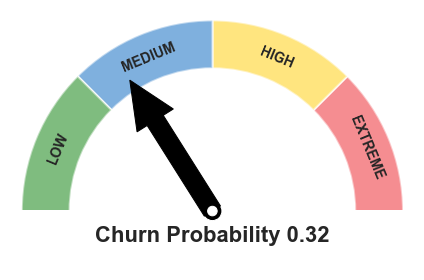

In [ ]:
gauge(Probability=model.predict_proba(test_x.iloc[0:1])[0,1])

Final Features

In [ ]:
test_x.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')